# Appendix D: Data analysis for presentation
Our goal at Airbnb is to increase bookings. Therefore, we will consider the "guest host matching process" a success if it increases the conversion of guest-host contact to bookings. It is a failure if a contact does not turn into a booking.

In [1]:
# Auto-reloads external files any changes are automatically reflected
%load_ext autoreload
%autoreload 2

# use this later to clean up output
import  warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette('bright')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# My own personal modules
import data_cleaning
import data_processing

# Data loading, cleaning, and processing

In [2]:
contacts = pd.read_csv('./contacts.csv')
listings = pd.read_csv('./listings.csv')
users = pd.read_csv('./users.csv')

In [3]:
data = data_cleaning.merge_data(contacts,listings,users)

In [ ]:
data = data_processing.process_data(data)

In [5]:
data.loc[data.holiday=='olympics','holiday_bin'] = 1
data.loc[data.holiday=='carnival','holiday_bin'] = 1
data.loc[data.holiday=='normal','holiday_bin'] = 0

# Analysis used in presentation

Sections are labeled by the following numbers.
0. The user path and booking outcomes
1. User behavior with listings with/without instant booking
2. Looking at inquiry conversion by host booking type (instant booking accepted or not)
3. Behavior of guests messaging multiple hosts; number of messages and conversion
4. Market activity (bookings and inquiries), holiday and non-holiday
5. Holidays reduce host likeliness to accept bookings

# 0. The user path and booking outcomes
Our goal is to increase bookings on the platform. 

We can classify host and guest responses as follows:
* host_ignore: Host does not respond to guest inquiry
* host_denies: Host denies the reservation request
* host_accepts: Host allows the customer to book
* guest_books: Guest converts acceptance into booking
* guest_ignores: Guest does not convert acceptance into booking
* guest_denied: Guest was not approved to book

We want to maximize the number of contacts that convert from inquiry > host_accepts > guest_books.

(This would be a great target for a Sankey diagram, I just didn't want to futz with the visualization settings under a time crunch.)

In [6]:
pivot = data.pivot_table(
                        index=['host_response','guest_response'],
                        values=["id_guest_anon"],
                        aggfunc='count',
                        margins="True")
pivot

id_guest_anon
host_response guest_response               
host_accepts  guest_books             11185
              guest_ignores            4379
host_denies   guest_denied             8919
host_ignores  guest_ignored            1969
All                                   26452

In [7]:
data['contact_channel_first'].value_counts()

contact_me      11964
book_it          7998
instant_book     6490
Name: contact_channel_first, dtype: int64

In [8]:
pivot = data[data.holiday=='normal'].pivot_table(
    index=['contact_channel_first','host_response','guest_response'],
                        values=["id_guest_anon"],
                        aggfunc='count',
                        margins="True")
pivot

id_guest_anon
contact_channel_first host_response guest_response               
book_it               host_accepts  guest_books              2756
                                    guest_ignores              95
                      host_denies   guest_denied             1021
                      host_ignores  guest_ignored             271
contact_me            host_accepts  guest_books               531
                                    guest_ignores            2164
                      host_denies   guest_denied             1789
                      host_ignores  guest_ignored             249
instant_book          host_accepts  guest_books              4559
All                                                         13435

Holy moly. We have a problem here!
* For `book_it`, only a little over half of initial messages (which have deposits with them!) convert to bookings
* For `contact_me`, hosts are ignoring or denying most requests, and guests rarely book
* For `instant_books`, all messages immediately move through the pipeline

Overall, less than half of all inquiries turn into bookings-- this is not great conversion!

Since these are users who are already invested in the platform, and in some cases have already made a deposit, there should theoretically be a very low activation barrier to convert them from message to booking.

This raises several questions.
* Why is `contact_me` so bad? Are users just using it to ask questions?
* Why are hosts denying so many guests?
* Is there any time dependence?
* Are users who do not book just booking somewhere else?

Let's see if this conversion rate changes with time.

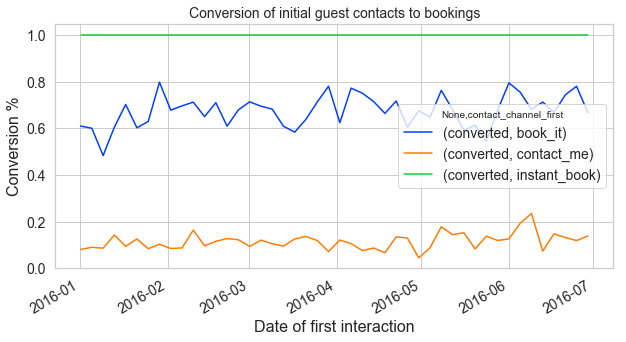

In [9]:
pivot = data[data.holiday=='normal'].pivot_table(index = ['ts_interaction_first'],
                               columns = ['contact_channel_first'],
                              aggfunc = 'mean',
                              values=['converted'])
#                               fill_value=0)
pivot = pivot.resample('4D').mean()

fig,ax = plt.subplots(figsize=(10,5))
pivot.plot(ax=ax)
ax.set_title('Conversion of initial guest contacts to bookings')
ax.set_ylabel('Conversion %')
ax.set_xlabel('Date of first interaction')
ax.set_ylim(0,None)
plt.show()

Conversion rate does not appear to be time-dependent on the date of first interaction, when holidays are accounted for. (Note that there's a phantom increase due to the Rio Olympics if that data is included)

Conversion of `book_it` is stagnant around 65%, while conversion of `contact_me` hovers between 10% and 20%.

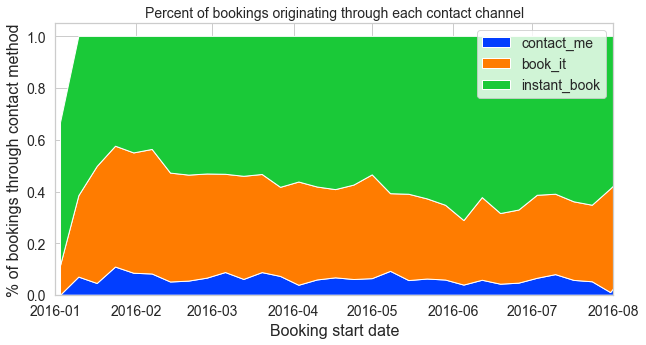

In [10]:
data_selection = data[data.holiday=='normal']
crosstab = pd.crosstab(data_selection['ds_checkin_first'],data_selection['contact_channel_first'],
                                        aggfunc = 'sum',
                                        values=data['converted'],
                                        normalize='index')
crosstab = crosstab.resample('W').mean()

fig,ax = plt.subplots(figsize=(10,5))
# crosstab.plot.bar(stacked=True,ax=ax)
plt.stackplot(crosstab.index,crosstab['contact_me'],crosstab['book_it'],crosstab['instant_book'], labels=['contact_me','book_it','instant_book'])
ax.set_ylabel('% of bookings through contact method')
ax.set_xlabel('Booking start date')
ax.set_title('Percent of bookings originating through each contact channel')
ax.set_ylim(0,None)
ax.set_xlim('2016-01-01','2016-08-01')
ax.legend()
plt.show()

While `contact_me` is driving the most message volume, it is not driving the most booking results. Over half of all bookings for the data available are coming from `instant_book`.

**We need to improve conversion messages to bookings.**
1. Incentivize users/hosts to user instant booking
2. Need to convert better on holiday bookings

# 1. User behavior with listings with/without instant booking

In [11]:
# we can ascertain whether the listing has opted-in to IB
sample = data[data.listing_booking_type_diff!=1]

# we can ascertain whether the host has opted-in to IB
sample = sample[sample.host_booking_type_diff!=1]

# we can figure out the opt-in status of a message
sample = sample[sample.host_booking_type!='-unknown-']

sample = sample[sample.holiday=='normal'] # no holidays

In [12]:
# step 1: User finds listing. Does it have instant booking?
sample.host_booking_type.value_counts()

instant_no     4933
instant_yes    3477
Name: host_booking_type, dtype: int64

In [13]:
# step 2: type of message sent?
# toggle normalization to reproduce % on slide
crosstab = pd.crosstab(sample.host_booking_type,
                       sample.contact_channel_first,
                       values=sample.converted,
                       aggfunc='count',
#                        normalize='index',
                       margins=True)
crosstab

contact_channel_first,book_it,contact_me,instant_book,All
host_booking_type,,,,
instant_no,3029.0,1904.0,NaN,4933
instant_yes,NaN,747.0,2730.0,3477
All,3029.0,2651.0,2730.0,8410


In [14]:
# step 3: how many messages of each type converted?
crosstab = pd.crosstab(sample.host_booking_type,
                       sample.contact_channel_first,
                       values=sample.converted,
                       aggfunc='sum',
                       margins=True)
crosstab

contact_channel_first,book_it,contact_me,instant_book,All
host_booking_type,,,,
instant_no,1962.0,233.0,NaN,2195.0
instant_yes,NaN,80.0,2730.0,2810.0
All,1962.0,313.0,2730.0,5005.0


In [15]:
# step 4: what was the conversion percentage?
crosstab = pd.crosstab(sample.host_booking_type,
                       sample.contact_channel_first,
                       values=sample.converted,
                       aggfunc='mean',
                       margins=True)
crosstab

contact_channel_first,book_it,contact_me,instant_book,All
host_booking_type,,,,
instant_no,0.647739,0.122374,NaN,0.444962
instant_yes,NaN,0.107095,1.0,0.808168
All,0.647739,0.118069,1.0,0.595125


# 2. Looking at inquiry conversion by host booking type (instant booking accepted or not)

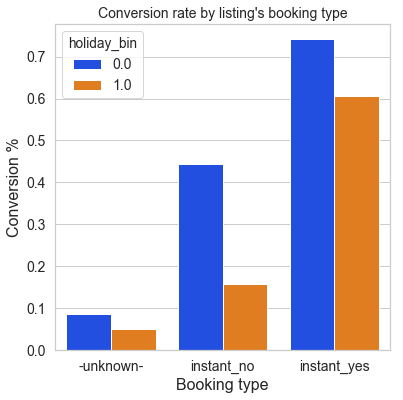

In [16]:
sample = data[data.listing_booking_type_diff!=1]

grouped = sample[['holiday_bin','converted','host_booking_type']].groupby(['host_booking_type','holiday_bin']).mean().reset_index()

fig,ax=plt.subplots(figsize=(6,6))
sns.barplot(x=grouped.host_booking_type,y=grouped.converted,hue=grouped.holiday_bin,ax=ax)
ax.set_ylabel('Conversion %')
ax.set_xlabel('Booking type')
ax.set_title("Conversion rate by listing's booking type")
plt.show()

In [17]:
# output this to convert to powerpoint chart for presentation
grouped

,host_booking_type,holiday_bin,converted
0,-unknown-,0.0,0.085202
1,-unknown-,1.0,0.050207
2,instant_no,0.0,0.444962
3,instant_no,1.0,0.156589
4,instant_yes,0.0,0.740928
5,instant_yes,1.0,0.606111


# 3. Behavior of guests messaging multiple hosts; number of messages and conversion
I'll calculate duplicate messages as those that were sent for the same target check-in week.

This isn't perfect, but should be directionally correct.

Apologies in advance to the reviewers-- the quickest way to get this data under a time crunch was the good old copy-paste-change method.

In [18]:
# get raw number of guest by: new/prior, holiday/non
crosstab = pd.crosstab(data.guest_user_stage_first,data.holiday_bin)
crosstab

holiday_bin,0.0,1.0
guest_user_stage_first,,
new,6823,8276
past_booker,6612,4741


I want to get the number of potential guests reaching out to duplicates by:
* New/Previous-booker
* Holidays/non-holiday

In [37]:
# non-holiday, new booker sending duplicate messages
sample = data[data.holiday=='normal']
sample = sample[sample.guest_user_stage_first=='new']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                            columns=['id_guest_anon'],
                             values=['m_interactions'],
                             aggfunc = 'count')
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 386
Average # of messages sent: 2.2487046632124352


In [38]:
# non-holiday, previous booker sending duplicate messages
sample = data[data.holiday=='normal']
sample = sample[sample.guest_user_stage_first=='past_booker']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                            columns=['id_guest_anon'],
                             values=['m_interactions'],
                             aggfunc = 'count')
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 358
Average # of messages sent: 2.170391061452514


In [39]:
# holiday, previous booker sending duplicate messages
sample = data[data.holiday!='normal']
sample = sample[sample.guest_user_stage_first=='new']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                            columns=['id_guest_anon'],
                             values=['m_interactions'],
                             aggfunc = 'count')
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 1210
Average # of messages sent: 2.3900826446280994


In [40]:
# holiday, previous bookers sending duplicate messages
sample = data[data.holiday!='normal']
sample = sample[sample.guest_user_stage_first=='past_booker']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                            columns=['id_guest_anon'],
                             values=['m_interactions'],
                             aggfunc = 'count')
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 785
Average # of messages sent: 2.3961783439490447


### A brief intermission to break up the blocks of copy pasta.
Next, I want to look at conversion of these same guests by holiday/non.

In [41]:
# holiday, non-converted users sending duplicate messages
sample = data[data.converted==0]
sample = sample[sample.holiday!='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 1604
Average # of messages sent: 2.4183291770573567


In [42]:
# non-holiday, non-converted users sending duplicate messages
sample = data[data.converted==0]
sample = sample[sample.holiday=='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 440
Average # of messages sent: 2.2954545454545454


In [43]:
# holiday, converted users sending duplicate messages
sample = data[data.converted==1]
sample = sample[sample.holiday!='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 120
Average # of messages sent: 2.1


In [44]:
# non-holiday, converted users sending duplicate messages
sample = data[data.converted==1]
sample = sample[sample.holiday=='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)>1)
avg_messages = np.mean(np.amax(pivot.values,axis=0)[np.amax(pivot.values,axis=0)>1])
print('Number of users sending multiple messages: '+ str(users))
print('Average # of messages sent: '+ str(avg_messages))

Number of users sending multiple messages: 102
Average # of messages sent: 2.0392156862745097


### Another intermission.
Now I need to look at guest who did *not* send multiple messages for my control.

In [45]:
# holiday, non-converted users NOT sending duplicate messages
sample = data[data.converted==0]
sample = sample[sample.holiday!='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with no more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)==1)
print('Number of users sending only one listing a message: '+ str(users))

Number of users sending only one listing a message: 5685


In [46]:
# non-holiday, non-converted users NOT sending duplicate messages
sample = data[data.converted==0]
sample = sample[sample.holiday=='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with no more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)==1)
print('Number of users sending only one listing a message: '+ str(users))

Number of users sending only one listing a message: 4413


In [47]:
# holiday, converted users NOT sending duplicate messages
sample = data[data.converted==1]
sample = sample[sample.holiday!='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with no more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)==1)
print('Number of users sending only one listing a message: '+ str(users))

Number of users sending only one listing a message: 3043


In [48]:
# non-holiday, converted users NOT sending duplicate messages
sample = data[data.converted==1]
sample = sample[sample.holiday=='normal']

pivot = sample.pivot_table(index=['ds_checkin_first'],
                         columns=['id_guest_anon'],
                         values=['m_interactions'],
                         aggfunc = 'count'
                        )
pivot = pivot.resample('W').sum()

# find max number of messages sent per ID, count user ids with no more than one max message in a target week
users = sum(np.amax(pivot.values,axis=0)==1)
print('Number of users sending only one listing a message: '+ str(users))

Number of users sending only one listing a message: 7363


A good metric would be reducing the number of messages sent for the same booking window. This would be a direct measure of the improved fit.

This could be (message inquiries for checkin date)/(booking for checkin date).

Many more un-converted users are the ones sending multiple messages. If we notice a user sending multiple messages, that could be a flag for us to "sweeten the pot". 

# 4. Market activity (bookings and inquiries), holiday and non-holiday

We should definitely not consider the Olympics in this-- that was a one-off case. Additionally, we're probably not accounting perfectly for Carnival, since it happened so soon after the start of this data set.

In [31]:
# number of messages
inquiries = data.holiday.value_counts()

# number of bookings
bookings = data[data.converted==1].holiday.value_counts()

In [32]:
inquiries

normal      13435
olympics     9766
carnival     3251
Name: holiday, dtype: int64

In [33]:
bookings

normal      7846
olympics    2799
carnival     540
Name: holiday, dtype: int64

# 5. Holidays reduce host likeliness to accept bookings

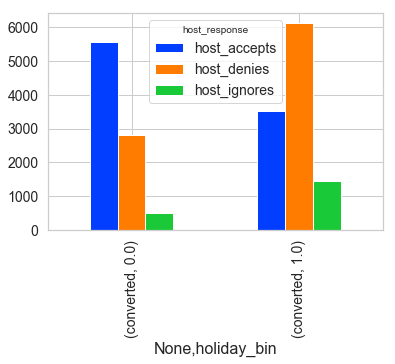

In [34]:
# number of responses by host_reponse, grouped by holiday/not
# remove instant booking, since those are automatically accepted by the host
sample = data[data.contact_channel_first!='instant_book']

pivot = sample.pivot_table(index=['host_response'],
                        columns=['holiday_bin'],
                         values=['converted'],
                        aggfunc='count')
pivot.transpose().plot.bar()

Hosts are MUCH less likely to accept requests to book during holidays. (During the holidays-- Rio or Carnival-- is 1, while not is 0).

Below, I'm going to output the values of that pivot table for plotting in the presentation.

In [35]:
pivot

converted      
holiday_bin         0.0   1.0
host_response                
host_accepts       5546  3528
host_denies        2810  6109
host_ignores        520  1449

It's worth noting that guests are part of the problem. During holiday periods, guests are more likely to ignore a booking acceptance than book afterwards! That's pretty nutty.

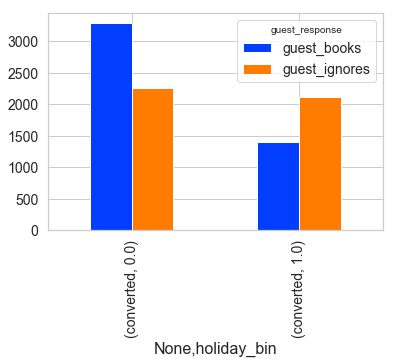

In [36]:
# number of responses by guest_reponse, grouped by holiday/none
# remove instant booking, since those are automatically accepted by the host
sample = data[data.contact_channel_first!='instant_book']
# screen for just where the host has accepted
sample = sample[sample.host_response=='host_accepts']

pivot = sample.pivot_table(index=['guest_response'],
                        columns=['holiday_bin'],
                         values=['converted'],
                        aggfunc='count')
pivot.transpose().plot.bar()